## Fitting out Baselines for the Broken-Up segments

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import os
from scipy import fft, arange, signal
from scipy.interpolate import interp1d
from scipy.optimize import fmin, fmin_powell
from lmfit import minimize, Parameters, report_fit, Model, Minimizer
from lmfit.models import GaussianModel, LinearModel, Model
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import interpolate
import pybroom as br

import seaborn as sns

import sys
sys.path.append(r'C:\Users\ema3\OneDrive - National Institute of Standards and Technology (NIST)\Python Scripts\HAPI')# set location of HAPI.py module
sys.path.append(r'C:\Users\ema3\OneDrive - National Institute of Standards and Technology (NIST)\Projects\Cold Cavity - O2 A Band')# set location of HAPI.py module
%matplotlib inline
from hapi import *
from hapi_supplemental_def import *
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")




HAPI version: 1.1.0.7


In [112]:
path = r'C:\Users\ema3\Desktop\Cold Cavity Oxygen A Band Pre-Processed\0.2%\290K\700 Torr\Labview'# Location of the Summary Data File
os.chdir(path)

filename = '5Nov17_290K_0.2%_700Torr_Seg17'
DATA = pd.read_csv(filename + ".csv")
temperature = 290
sample = 1

if sample == 1:
    percent_oxygen = 0.2022 # percentage
    isotopes = [36]
    natural_abundance = False
elif sample == 2:
    percent_oxygen = 1.9734 
    isotopes = [36, 37, 38]
    natural_abundance = True
elif sample == 3:
    percent_oxygen = 14.979 
    isotopes = [36]
    natural_abundance = False

if temperature == 290:
    etalon_mirror = [0.00598, 24.648458*1000] 
    etalon_window = [0.00108,7.352352*1000]
    etalon_slow = [0.000884, 158.269045*1000]
    etalon_fast  = [0.000437, 12.349535*1000]
elif temperature == 273:
    if sample != 1:
        etalon_mirror = [0.00566, 24.680022*1000] 
        etalon_window = [0.00108,7.352778*1000]
        etalon_slow = [0.000813, 154.408341*1000]
        etalon_fast  = [0.000440, 12.36535*1000]
    elif sample == 1:
        etalon_mirror = [0.00580, 24.780043*1000] 
        etalon_window = [0.00109,7.356575*1000]
        etalon_slow = [0.00139, 156.940272*1000]
        etalon_fast  = [0.000432, 12.335917*1000]
elif temperature == 255:
    if sample != 1:
        etalon_mirror = [0.00507, 24.756192*1000] 
        etalon_window = [0.00108,7.354223*1000]
        etalon_slow = [0, 154.408*1000]
        etalon_fast  = [0.000429, 12.352679*1000]
    elif sample == 1:
        etalon_mirror = [0.00501, 24.824664*1000] 
        etalon_window = [0.00107,7.360413*1000]
        etalon_slow = [0.00143, 170.669565*1000]
        etalon_fast  = [0.000443, 12.356168*1000]
elif temperature == 237:
    etalon_mirror = [0.005000, 24.727861*1000] 
    etalon_window = [0.00107,7.354798*1000]
    etalon_slow = [0.000921, 171.68201*1000]
    etalon_fast  = [0.000441, 12.363931*1000]






In [113]:
def max_iter(pars, iter, resid, *args, **kws):
        if iter > 1000:
            return True
        else:
            return False
def etalon(x, amp, period, phase):
    return amp*np.sin((2*np.pi / period)*x+ phase)

def etalon_linear(x, amp, f0, phase, alpha):
    #based on a linear chirp
    f1 = alpha*f0
    k = (f1 - f0) / (x[-1] - x[0])
    return amp*np.sin(2*np.pi*(f0*x + 0.5*k*x**2)+ phase)

def etalon_model(params, x):
    #Etalon Parameters
    ##Mirror Etalon
    amp_1 = np.float(params['amp_1'])
    freq_1 = np.float(params['freq_1'])
    phase_1 = np.float(params['phase_1'])
    alpha_1 = np.float(params['alpha_1'])
    
    ## Other Etalon
    amp_2 = np.float(params['amp_2'])
    freq_2 = np.float(params['freq_2'])
    phase_2 = np.float(params['phase_2'])
    alpha_2 = np.float(params['alpha_2'])
    
    ## Slow Other Etalon
    amp_3 = np.float(params['amp_3'])
    freq_3= np.float(params['freq_3'])
    phase_3 = np.float(params['phase_3'])
    alpha_3 = np.float(params['alpha_3'])
    alpha_3 = np.float(params['alpha_3'])
    
    ## Fast Other Etalon
    amp_4 = np.float(params['amp_4'])
    freq_4= np.float(params['freq_4'])
    phase_4 = np.float(params['phase_4'])
    alpha_4 = np.float(params['alpha_4'])
    
    etalon_1 = etalon_linear(x, amp_1, freq_1, phase_1, alpha_1)
    etalon_2 = etalon_linear(x, amp_2, freq_2, phase_2, alpha_2)
    etalon_3 = etalon_linear(x, amp_3, freq_3, phase_3, alpha_3)
    etalon_4 = etalon_linear(x, amp_4, freq_4, phase_4, alpha_4)
    etalons = etalon_1 + etalon_2 + etalon_3 + etalon_4
    
    return etalons
    

def sim_model(params, x, data, DF):
    #Baseline Parameters
    
    y_slope = np.float(params['y_slope'])
    y_shift = np.float(params['y_shift'])
    #x_shift = np.float(params['x_shift'])
    
    # Line Parameters
    for i in range(0, length('tmp')): 
        if (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DF['Wavenumber (FSR)'].min(), 2) - 1.5)) and (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DF['Wavenumber (FSR)'].min(), 2) + 1.5)):
            if LOCAL_TABLE_CACHE['tmp']['data']['sw'][i] >= 1e-24:
                LOCAL_TABLE_CACHE['tmp']['data']['nu'][i] = np.float(params['nu_%i'%(i)])
                LOCAL_TABLE_CACHE['tmp']['data']['sw'][i] = np.float(params['sw_%i'%(i)])
                LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i] = np.float(params['gamma_air_%i'%(i)])
                LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i] = np.float(params['delta_air_%i'%(i)])
                LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i] = np.float(params['SD_air_%i'%(i)])
                LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i] = np.float(params['y_air_%i'%(i)])

        
   
    #saveCache() ABSORB_COEFF
    nu_Drouin,Drouin_coef = ABSORB_COEFF(Components = MID, 
                                    SourceTables='tmp',OmegaStep=0.001,Environment={'p':pressure,'T':temperature}, 
                                    GammaL = 'gamma_air', 
                                   IntensityThreshold = 1e-30, HITRAN_units =False, 
                                       WavenumberWingHW = 100)
    Drouin_Alpha = Drouin_coef*1e6 
    freq_Drouin = (nu_Drouin*29979245800) / 1e6
    #freq_Drouin += x_shift
    f = interpolate.interp1d(freq_Drouin, Drouin_Alpha, fill_value = 0, bounds_error = False)
    Drouin_coef_interp_lm = f(x)
    etalons = etalon_model(params, x)
  
    simulated_spectra = Drouin_coef_interp_lm + y_shift + y_slope*x + etalons
    return simulated_spectra - data


hapi = r'C:\Users\ema3\OneDrive - National Institute of Standards and Technology (NIST)\Projects\Cold Cavity - O2 A Band' # Location of the Summary Data File
os.chdir(hapi)

db_begin()

Using .

Drouin_2016
                     Lines parsed: 489
HITRAN
                     Lines parsed: 489
Long_2011
                     Lines parsed: 559
sampletab
                     Lines parsed: 3
SDVP check
                     Lines parsed: 3


In [ ]:
MID = []
concentration = {'O2' : percent_oxygen / 100}
for isotope in isotopes: # Currently based on one molecule
    if natural_abundance == True:
        MID.append((ISO_ID[isotope][ISO_ID_INDEX['M']],ISO_ID[isotope][ISO_ID_INDEX['I']], concentration[ISO_ID[isotope][ISO_ID_INDEX['mol_name']]]* ISO_ID[isotope][ISO_ID_INDEX['abundance']]))
    elif natural_abundance == False:
        MID.append((ISO_ID[isotope][ISO_ID_INDEX['M']],ISO_ID[isotope][ISO_ID_INDEX['I']], concentration[ISO_ID[isotope][ISO_ID_INDEX['mol_name']]] ))#* ISO_ID[isotope][ISO_ID_INDEX['abundance']]

        
params = Parameters()
copy_etalon = True
DBfromsource = True
center_vary = True
intensity_vary = True
width_vary = True
shift_vary = False
sd_vary = True
nuVC_vary = False
y_vary = True
etalon_1_on = True
etalon_2_on = True
etalon_3_on =True
etalon_4_on = True
Filter_save = False

pressure = DATA['Cavity Pressure /Torr'].mean()*0.00131579
temperature = DATA['Cavity Temperature Side 2 /C'].mean() +273.15

# Define Background Parameters
params.add('y_slope', 0, vary = True, min = -1, max = 1)
params.add('y_shift', 0, vary = True, min = -1, max = 1)
#params.add('x_shift', 0, vary = True, min = -10, max = 10)

# Define Etalon Parameters
if etalon_1_on == False:  
    params.add('amp_1',0, vary=False)
    params.add('freq_1', 1 / etalon_mirror[1], vary = False, min = (1 / etalon_mirror[1])*0.8, max = (1 / etalon_mirror[1])*1.2)
    params.add('phase_1',0, vary = False)
    params.add('alpha_1', 1, vary = False)
elif etalon_1_on == True:
    params.add('amp_1',etalon_mirror[0], vary=True, min = 0.5*etalon_mirror[0], max = 2*etalon_mirror[0])
    params.add('freq_1', 1 / etalon_mirror[1], vary = False, min = (1 / etalon_mirror[1])*0.8, max = (1 / etalon_mirror[1])*1.2)
    params.add('phase_1',0, vary = True, min = -np.pi, max = np.pi)
    params.add('alpha_1', 1, vary = False, min = 0.99, max = 1.01)
if etalon_2_on == False:  
    params.add('amp_2',0, vary=False)
    params.add('freq_2',1 / etalon_window[1], vary = False)
    params.add('phase_2',0, vary =False)
    params.add('alpha_2', 1, vary = False)
if etalon_2_on == True:
    params.add('amp_2',etalon_window[0], vary=False, min = etalon_window[0]*0.5, max = etalon_window[0]*2)
    params.add('freq_2',1 / etalon_window[1], vary = False, min = (1 /  etalon_window[1])*0.8, max = (1 / etalon_window[1])*1.2)
    params.add('phase_2',0, vary =True, min = -np.pi, max = np.pi)
    params.add('alpha_2', 1, vary = False, min = 0.98, max = 1.02)
if etalon_3_on == False:  
    params.add('amp_3',0, vary=False)
    params.add('freq_3',1 / etalon_slow[1], vary = False)
    params.add('phase_3',0, vary =False)
    params.add('alpha_3', 1, vary = False)
if etalon_3_on == True:
    params.add('amp_3',etalon_slow[0], vary=True, min =  etalon_slow[0]*0.5, max = etalon_slow[0]*2)
    params.add('freq_3',1 / etalon_slow[1], vary = False, min = (1 /  etalon_slow[1])*0.8, max = (1 / etalon_slow[1])*1.2)
    params.add('phase_3',0, vary =True, min = -np.pi, max = np.pi)
    params.add('alpha_3', 1, vary = False, min = 0.99, max = 1.01)
if etalon_4_on == False:  
    params.add('amp_4',0, vary=False)
    params.add('freq_4',1 / etalon_fast[1], vary = False)
    params.add('phase_4',0, vary =False)
    params.add('alpha_4', 1, vary = False)
if etalon_4_on == True:
    params.add('amp_4',etalon_fast[0], vary=False, min = etalon_fast[0]*0.5, max = etalon_fast[0]*2)
    params.add('freq_4',1 / etalon_fast[1], vary = False, min = (1 /  etalon_fast[1])*0.8, max = (1 / etalon_fast[1])*1.2)
    params.add('phase_4',0, vary =True, min = -np.pi, max = np.pi)
    params.add('alpha_4', 1, vary = False, min = 0.98, max = 1.02)



# Define Lineshape parameters
if DBfromsource == True:
    Cond = ('AND',('BETWEEN','nu',np.floor(DATA['Wavenumber (FSR)'].min() - 5),np.ceil(DATA['Wavenumber (FSR)'].max() + 5)),('>=','sw',1e-30))
    select('Drouin_2016',Conditions=Cond,DestinationTableName='tmp')
    LOCAL_TABLE_CACHE['tmp']['data']['y_air'] = len( LOCAL_TABLE_CACHE['tmp']['data']['y_air'])*[0]

for i in range(0, length('tmp')):
    if (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DATA['Wavenumber (FSR)'].min(), 2) - 1.5)) and (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DATA['Wavenumber (FSR)'].min(), 2) + 1.5)):
        #params.add('sw_%i'%(i),np.float(LOCAL_TABLE_CACHE['tmp']['data']['sw'][i]), vary = intensity_vary)
        #params.add('gamma_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]), vary = width_vary, min = 0.5*np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]), max =  2*np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]))
        #params.add('delta_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]), vary = shift_vary, min = 0.5*np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]), max =  2*np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]))
        if LOCAL_TABLE_CACHE['tmp']['data']['sw'][i] >= 1e-24:
            params.add('nu_%i'%(i),np.float(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i]), vary = center_vary, min = np.float(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i])-0.25,  max = np.float(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i])+0.25)
            params.add('sw_%i'%(i),np.float(LOCAL_TABLE_CACHE['tmp']['data']['sw'][i]), vary = intensity_vary)
            params.add('gamma_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]), vary = width_vary, min = 0.5*np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]), max =  2*np.float(LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i]))
            params.add('delta_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]), vary = shift_vary, min = 0.5*np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]), max =  2*np.float(LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i]))
            if LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i] != 0:
                params.add('SD_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i]), vary = sd_vary, min = 0.5*np.float(LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i]), max =  2*np.float(LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i]))
            else:
                params.add('SD_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i]), vary = False)
            if LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i] != 0:
                params.add('y_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i]), vary = y_vary, min = -2*np.abs(np.float(LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i])), max =  2*np.abs(np.float(LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i])))
            else:
                params.add('y_air_%i'%(i), np.float(LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i]), vary = False)
            #params.add('nu_HT_air_%i'%(i), 0, vary = nuVC_vary, min = -0.2, max = 0.2)        
    
if copy_etalon == True:
    params.add('y_slope', np.float(str(result.params['y_slope']).split()[2][6:]), vary = True, min = -1, max = 1)
    params.add('y_shift', np.float(str(result.params['y_shift']).split()[2][6:]), vary = True, min = -1, max = 1)
    if etalon_1_on == True:
    #np.float(str(result.params['nu_%i'%(i)]).split()[2][6:])
        params.add('amp_1',np.float(str(result.params['amp_1']).split()[2][6:]), vary=True, min = 0.5*etalon_mirror[0], max = 2*etalon_mirror[0])
        params.add('phase_1',np.float(str(result.params['phase_1']).split()[2][6:]), vary = True, min = -np.pi, max = np.pi)
    if etalon_2_on == True:
        params.add('amp_2',np.float(str(result.params['amp_2']).split()[2][6:]), vary=False, min = etalon_window[0]*0.5, max = etalon_window[0]*2)
        params.add('phase_2',np.float(str(result.params['phase_2']).split()[2][6:]), vary =True, min = -np.pi, max = np.pi)
    if etalon_3_on == True: 
        params.add('amp_3',np.float(str(result.params['amp_3']).split()[2][6:]), vary=True, min =  etalon_slow[0]*0.5, max = etalon_slow[0]*2)
        params.add('phase_3',np.float(str(result.params['phase_3']).split()[2][6:]), vary =True, min = -np.pi, max = np.pi)
    if etalon_4_on == True:
        params.add('amp_4',np.float(str(result.params['amp_4']).split()[2][6:]), vary=False, min = etalon_fast[0]*0.5, max = etalon_fast[0]*2)
        params.add('phase_4',np.float(str(result.params['phase_4']).split()[2][6:]), vary =True, min = -np.pi, max = np.pi)
    
start_ = (np.arange(0,50))    
end_ = (np.arange(625,697))  
ignore_pts = []
ignore_pts = np.append(ignore_pts, start_)
ignore_pts = np.append(ignore_pts, end_)
filter_pts = []

DATA['Filter'] = len(DATA)*[0]
for pt in ignore_pts:
    DATA.loc[DATA.index == pt, 'Filter'] = 1
for pt in filter_pts:
    DATA.loc[DATA.index == pt, 'Filter'] = 2

x = DATA[DATA['Filter'] ==0]['Frequency (FSR) /MHz'].values
y = DATA[DATA['Filter'] ==0]['Alpha - Baseline Corrected'].values


minner = Minimizer(sim_model, params,fcn_args=(x, y, DATA), iter_cb = max_iter)
result = minner.minimize(method = 'leastsq')#'
final = y + result.residual

print (report_fit(result))
print (np.std(result.residual))

# Update Lineshape parameters
for i in range(0, length('tmp')):
    if (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DATA['Wavenumber (FSR)'].min(), 2) - 1.5)) and (np.around(LOCAL_TABLE_CACHE['tmp']['data']['nu'][i], 2) > (np.around(DATA['Wavenumber (FSR)'].min(), 2) + 1.5)):
        if LOCAL_TABLE_CACHE['tmp']['data']['sw'][i] >= 1e-24:
            LOCAL_TABLE_CACHE['tmp']['data']['nu'][i] = np.float(str(result.params['nu_%i'%(i)]).split()[2][6:])
            LOCAL_TABLE_CACHE['tmp']['data']['sw'][i] = np.float(str(result.params['sw_%i'%(i)]).split()[2][6:])
            LOCAL_TABLE_CACHE['tmp']['data']['gamma_air'][i] = np.float(str(result.params['gamma_air_%i'%(i)]).split()[2][6:])
            LOCAL_TABLE_CACHE['tmp']['data']['delta_air'][i] = np.float(str(result.params['delta_air_%i'%(i)]).split()[2][6:])
            LOCAL_TABLE_CACHE['tmp']['data']['SD_air'][i] = np.float(str(result.params['SD_air_%i'%(i)]).split()[2][6:])
            LOCAL_TABLE_CACHE['tmp']['data']['y_air'][i] = np.float(str(result.params['y_air_%i'%(i)]).split()[2][6:])
            #LOCAL_TABLE_CACHE['tmp']['data']['nu_HT_air'][i] = np.float(str(result.params['nu_HT_air_%i'%(i)]).split()[2][6:])


DATA['Residuals'] = len(DATA)*np.nan
DATA.loc[DATA['Filter'] == 0, 'Residuals'] = result.residual

DATA['Etalons'] = etalon_model(result.params, DATA['Frequency (FSR) /MHz'].values)
DATA['Model'] = sim_model(result.params, DATA['Frequency (FSR) /MHz'].values, DATA['Alpha - Baseline Corrected'].values, DATA) + DATA['Alpha - Baseline Corrected']
DATA['Alpha - Baseline and Etalon'] = DATA['Alpha - Baseline Corrected'] - DATA['Etalons']
if Filter_save == True:
    DATA.loc[DATA['Filter']== 2, 'Alpha - Baseline and Etalon'] = DATA[DATA['Filter'] == 2]['Model'] - DATA[DATA['Filter'] == 2]['Etalons']





fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax0.plot(x, final, "-")
ax0.plot(x, y, ".")
ax0.set_ylabel('$\\frac{1}{c \\tau} (ppm/cm)$')
#ax0.set_ylim(0, 0.2)
#ax0.set_xlim(13090, 13110)

ax1 = plt.subplot(gs[1])
ax1.plot(x, result.residual, ".")
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Residuals')
#ax1.set_xlim(13090, 13110)
#ax1.set_ylim(-0.01, 0.01)
plt.show()






In [119]:
print (DATA[np.abs(DATA['Residuals'].values) > 5*DATA['Residuals'].std()])

os.chdir(path + '\Etalon Removed')
DATA.to_csv(filename + 'etalon.csv', index = False)
d =  (result.params.valuesdict())
f = open(filename + '_fit.csv','w')
for i in d:
    f.write(str(i) + ','+ str(d[i]) + '\n')
f.close()

          Date        Time  Number of Jumps  Actual Point Number  \
694  11/6/2017  6:27:08 AM            341.0              26713.0   
695  11/6/2017  6:27:08 AM            341.0              26714.0   
696  11/6/2017  6:27:08 AM            341.0              26715.0   

     Aquired Point Number  FARS Point Number  Carrier Frequency /MHz  \
694               26713.0               26.0            3.944784e+08   
695               26714.0               27.0            3.944784e+08   
696               26715.0               28.0            3.944784e+08   

     Sideband Frequency /MHz  Total Frequency /MHz  Mean tau/us  \
694              6684.219600          3.944850e+08    11.097624   
695              6871.094228          3.944852e+08    10.948556   
696              7057.654064          3.944854e+08    10.781355   

                ...               Wavenumber (FSR)  Empty Cavity Baseline  \
694             ...                   13158.604647               2.685404   
695            

C:\Users\ema3\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ema3\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\ema3\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide


    Frequency  Amplitude     Phase         GHz
0    0.000026   0.001157  0.001157   38.896935
1    0.000017   0.000714  0.000714   58.345403
2    0.000009   0.000473  0.000473  116.690805
3    0.000069   0.000377  0.000377   14.586351
4    0.000077   0.000350  0.000350   12.965645
5    0.000060   0.000293  0.000293   16.670115
6    0.000111   0.000291  0.000291    8.976216
7    0.000094   0.000256  0.000256   10.608255
8    0.000034   0.000250  0.000250   29.172701
9    0.000120   0.000229  0.000229    8.335058
10   0.000051   0.000211  0.000211   19.448468
11   0.000043   0.000202  0.000202   23.338161
12   0.000154   0.000171  0.000171    6.482823
13   0.000086   0.000164  0.000164   11.669081
14   0.000129   0.000157  0.000157    7.779387
15   0.000171   0.000136  0.000136    5.834540
16   0.000214   0.000136  0.000136    4.667632
17   0.000163   0.000125  0.000125    6.141621
18   0.000197   0.000113  0.000113    5.073513
19   0.000146   0.000112  0.000112    6.864165


C:\Users\ema3\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide


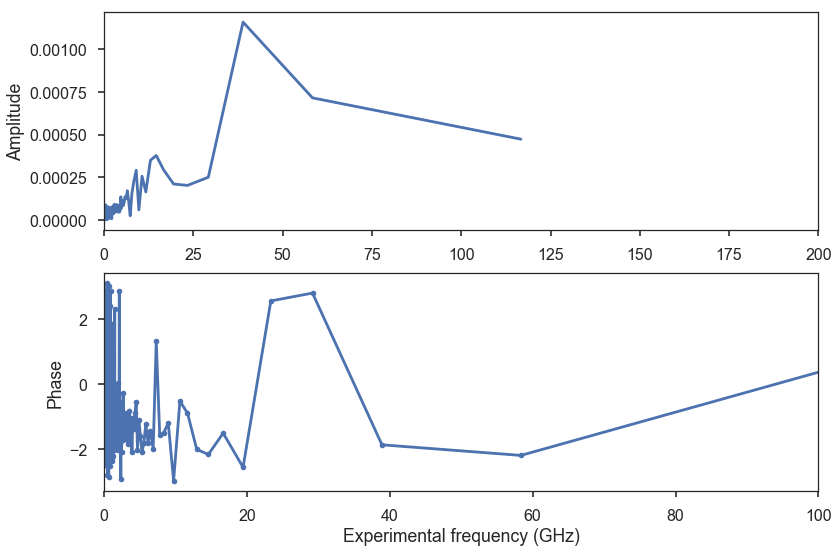

,Frequency,Amplitude,Phase,GHz
0,0.000000,1.539015e-12,1.539015e-12,inf
1,0.000009,4.727996e-04,4.727996e-04,116.690805
2,0.000017,7.141685e-04,7.141685e-04,58.345403
3,0.000026,1.157101e-03,1.157101e-03,38.896935
4,0.000034,2.503090e-04,2.503090e-04,29.172701
5,0.000043,2.023805e-04,2.023805e-04,23.338161
6,0.000051,2.105588e-04,2.105588e-04,19.448468
7,0.000060,2.925977e-04,2.925977e-04,16.670115
8,0.000069,3.772140e-04,3.772140e-04,14.586351
9,0.000077,3.495181e-04,3.495181e-04,12.965645


In [108]:
def FFT_EmptyCavity(DF):
    
    temp = DF[np.isfinite(DF['Residuals'])]
    nu = temp['Total Frequency /MHz'].values
    y = temp['Residuals'].values
    nu_step = (temp['FSR'].mean())
    
    A = np.fft.rfft(y)
    fft_freq = np.fft.rfftfreq(nu.shape[-1],nu_step)
    fft_amplitude = np.sqrt(A.real**2+A.imag**2)  / (len(A))
    fft_phase = np.arctan2(A.imag,A.real)
    
    FFT = pd.DataFrame()
    FFT['Frequency'] = fft_freq
    FFT['Amplitude'] = fft_amplitude
    FFT['Phase'] = fft_amplitude
    FFT['GHz'] = (1/(fft_freq))*0.001

    
    fft_ =FFT.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    fft_ =  (fft_[fft_['Amplitude']>1e-4].sort(['Amplitude'], ascending = [0]).reset_index(drop = True))
    
    print (fft_.loc[0:20])
    
    plt.subplot(211)
    plt.plot((1/fft_freq) * 0.001,fft_amplitude, "-")
    plt.ylabel('Amplitude')
    plt.xlim(0, 200)
    plt.subplot(212)
    plt.plot((1/fft_freq) * 0.001,fft_phase, ".-")
    plt.xlabel('Experimental frequency (GHz)')
    plt.ylabel('Phase')
    plt.xlim(0, 100)
    plt.show()

    return (FFT)

FFT_EmptyCavity(DATA)